**Andrew Lubawy, EE**

**Due: 3/28/2017**

# Two-Transmission-Link Queueing System Simulator and Output

***

## Code

In [1]:
%matplotlib inline
from pylab import *
import numpy as np
from collections import deque

This section of code implements a queue data type for use in my simulation. It can enqueue which adds an item to the back of the queue and is FIFO for dequeueing. Doing it this way closely represents a real queue and lets me easily track objects in the queue.

In [2]:
class Queue:
    """A queue for use in simulating M/M/1/k.
    
    Attributes:
        k (int): Maximum customers allowed in the system.
        departures (list): A sample of departure intervals.
        queue (list): A deque object.
        dropped (int): Number of items dropped because queue was full.
        served (int): Number of items served from queue.
    """
    
    def __init__(self, k, mu, departures):
        """Forms a queue.

        Args:
            k (int): Maximum customers allowed in the system.
            mu (float): Rate out of the queue.
            departures (int): Number of departure intervals to generate.
        """
        self.k = k
        # Generates the departure intervals
        # according to an exponential distribution.
        self.departures = exponential(1/mu, departures)
        self.queue = deque([], k)
        self.dropped = 0
        self.served = 0
        
    def empty(self):
        """Checks if the queue is empty.
        
        Returns:
            True if empty, False otherwise.
        """
        return len(self.queue) is 0
    
    def is_full(self):
        """Checks if the queue is full.
        
        Returns:
            True if full, False otherwise.
        """
        return len(self.queue) is self.k
    
    def enqueue(self, item):
        """Adds an item to end of the queue.
        
        Args:
            item: An item to add to the queue.
        """
        if self.is_full():
            self.dropped += 1
        else:
            self.queue.append(item)
        
    def dequeue(self):
        """Removes the fist item from the queue."""
        if not self.empty():
            self.served += 1
            return self.queue.popleft()
        return None
            
    def get_size(self):
        """Get the size of the queue.
        
        Returns:
            An integer for the size of the queue.
        """
        return len(self.queue)

This next piece of code performs the actual simulation and keeps track of everything. My method generates some arrival interval according to an exponential distribution with relation to $\lambda$. I then check if the time is 0 to handle an edge case by immediately adding to the queue. To do that I need to generate a uniformly distributed random variable to compare with $\phi$ and determine which queue to use. I then add that arrival time to the queue for use later and to simulate a packet entering. With that out of the way I then go through a series of checks to make sure packets are dequeueing according to exponential service times with relation to $\mu$. If anything should be dequeued I can then check its arrival time that I stored when dequeueing with the current time to determine delay while also incrementing a counter to check the number of packets serviced. Next, I'll have to enqueue whatever arrived after all dequeues finished, if any. When doing this I go through an important check. I will increment a dropped counter if the queue I'm adding to is full which helps me determine blocking. If it successfully queues I can then increment a counter which checks how full the queue is at certain points during the runtime. This counter also decreases during dequeues, and it helps me determine the average number of packets in the queue.


The latter portion of the code block contains equations and methods to output the expected metrics and the ones simulated in an easily readable format.

In [3]:
def simulation(lamb, mu, k, phi, samples):
    """Used to run a simulation of an M/M/1/k network.
    
    Args:
        lamb (float): The rate into the entire network.
        mu (float): The rate out of the two queues in the network.
        k (int): Maximum number of customers the two queues can handle.
        phi (float): Probability an arrival goes to the first queue.
        samples (int): Number of packets to sample. Defaults to 6000.
    """
    queue1 = Queue(k, mu, samples*2)
    queue2 = Queue(k, mu, samples*2)
    # Counts arrivals to each node.
    queue1_arrivals, queue2_arrivals = 0, 0
    # Count time passed.
    time = 0
    # Indexes for sample space lists.
    i, j, n, m = 0, 0, 0, 0
    # Lists for obtaining average number of packets and time in queue.
    queue1_size, queue2_size = [], []
    queue1_time, queue2_time = [0], [0]
    # Iterate over entire sample of arrivals.
    while queue1.served < samples and queue2.served < samples:
        # Generate an interarrival time.
        arrivals = exponential(1/lamb)
        # Idle state, ignores output rates.
        if time is 0:
            if random() < phi:
                queue1_arrivals += 1
                queue1.enqueue(0)
            else:
                queue2_arrivals += 1
                queue2.enqueue(0)
            # Increments time by one arrival interval.
            time += arrivals
        else:
            # Dequeues any packets that should have been processed
            # before the next arrival.
            while queue1.departures[i] <= time:
                t = queue1.dequeue() 
                if t is not None:
                    queue1_time.append(queue1.departures[i] - t)
                # Sums the intervals to compare with time since arrival.
                queue1.departures[i+1] += queue1.departures[i]
                i += 1
                if queue1.served > 1000:
                    queue1_size.append(queue1.get_size())
            while queue2.departures[j] <= time:
                t = queue2.dequeue() 
                if t is not None:
                    queue2_time.append(queue2.departures[j] - t)
                queue2.departures[j+1] += queue2.departures[j]
                j += 1
                if queue2.served > 1000:
                    queue2_size.append(queue2.get_size())
            # Splits arrivals based on phi probability.
            if random() < phi:
                queue1_arrivals += 1
                queue1.enqueue(time)
            else:
                queue2_arrivals += 1
                queue2.enqueue(time)
            if queue1.served > 1000 or queue2.served > 1000:
                queue1_size.append(queue1.get_size())
                queue2_size.append(queue2.get_size())
            # Increments time by one arrival interval.
            time += arrivals
    
    # Print the metrics for the queues.
    print_metrics(lamb, mu, k, phi, samples, time,
                  queue1, queue1_arrivals, queue1_size, queue1_time,
                  queue2, queue2_arrivals, queue2_size, queue2_time)

def print_metrics(lamb, mu, k, phi, samples, time,
                  queue1, queue1_arrivals, queue1_size, queue1_time,
                  queue2, queue2_arrivals, queue2_size, queue2_time):
    """Prints the metrics for the system, queue1, and queue2.
    
    Args:
        lamb (float): The rate into the entire network.
        mu (float): The rate out of the two queues in the network.
        k (int): Maximum number of customers the two queues can handle.
        phi (float): Probability an arrival goes to the first queue.
        samples (int): Number of packets sampled.
        time: The runtime of the system.
        queue1 (Queue): The first Queue object.
        queue1_arrivals: The number of arrivals into the system.
        queue1_size (list): A list of the number of items in queue at different times.
        queue1_time (list): A list of the delay for each packet that left the system.
        queue2 (Queue): The second Queue object.
        queue2_arrivals: The number of arrivals into the system.
        queue2_size (list): A list of the number of items in queue at different times.
        queue2_time (list): A list of the delay for each packet that left the system.
    """
    # Calculate and print results.
    # Queue 1.
    # Blocking probability. 
    e_pb1 = eval_blocking(lamb*phi, mu, k)
    pb1 = queue1.dropped/queue1_arrivals
    # Average delay.
    e_et1 = eval_delay(lamb*phi, mu, k, e_pb1)
    et1 = average(queue1_time)
    # Average number of packets in system.
    rho = phi*lamb/mu
    e_n1 = (rho/(1-rho))-((k+1)*rho**(k+1)/(1-rho**(k+1)))
    n1 = average(queue1_size)
    # Throughput.
    e_thru1 = e_n1/e_et1
    thru1 = n1/et1
    # Queue 2.
    # Blocking probability.
    e_pb2 = eval_blocking(lamb*(1-phi), mu, k)
    pb2 = queue2.dropped/queue2_arrivals
    # Average delay.
    e_et2 = eval_delay(lamb*(1-phi), mu, k, e_pb2)
    et2 = average(queue2_time)
    # Average number of packets in system.
    rho = (1-phi)*lamb/mu
    e_n2 = (rho/(1-rho))-((k+1)*rho**(k+1)/(1-rho**(k+1)))
    n2 = average(queue2_size)
    # Throughput.
    e_thru2 = e_n2/e_et2
    thru2 = n2/et2
    # Whole system.
    # Blocking probability.
    e_pb = phi*e_pb1 + (1-phi)*e_pb2
    pb = (queue1.dropped+queue2.dropped)/(queue1_arrivals + queue2_arrivals)
    # Average number of packets in system.
    e_n = e_n1 + e_n2
    n = n1 + n2
    # Average delay.
    e_et = e_n/(lamb*(1-e_pb))
    et = average(queue1_time+queue2_time)
    # Throughput.
    e_thru = e_thru1 + e_thru2
    thru = n/et
    
    print("\nSimulation of two M/M/1/{0} queues with phi={1}:\n".format(k,phi))
    # Whole system.
    system_metrics = {'expected_blocking':e_pb, 'blocking':pb, 'expected_delay':e_et, 'delay':et,
              'expected_number':e_n, 'number':n, 'expected_throughput':e_thru, 'throughput':thru}
    print("\tSystem:")
    print("\t\tBlocking probability:\n\t\t\tExpected: ", e_pb)
    print("\t\t\tSimulated: ", pb)
    print("\t\tAverage delay in seconds:\n\t\t\tExpected: ", e_et)
    print("\t\t\tSimulated: ", et)
    print("\t\tAverage number of packets:\n\t\t\tExpected: ", e_n)
    print("\t\t\tSimulated: ", n)
    print("\t\tThroughput in packets/second:\n\t\t\tExpected: ", e_thru)
    print("\t\t\tSimulated: ", thru)
    # Queue 1.
    queue1_metrics = {'expected_blocking':e_pb, 'blocking':pb, 'expected_delay':e_et, 'delay':et,
              'expected_number':e_n, 'number':n, 'expected_throughput':e_thru, 'throughput':thru}
    print("\n\tQueue 1:")
    print("\t\tBlocking probability:\n\t\t\tExpected: ", e_pb1)
    print("\t\t\tSimulated: ", pb1)
    print("\t\tAverage delay in seconds:\n\t\t\tExpected: ", e_et1)
    print("\t\t\tSimulated: ", et1)
    print("\t\tAverage number of packets:\n\t\t\tExpected: ", e_n1)
    print("\t\t\tSimulated: ", n1)
    print("\t\tThroughput in packets/second:\n\t\t\tExpected: ", e_thru1)
    print("\t\t\tSimulated: ", thru1)
    # Queue 2.
    queue2_metrics = {'expected_blocking':e_pb, 'blocking':pb, 'expected_delay':e_et, 'delay':et,
              'expected_number':e_n, 'number':n, 'expected_throughput':e_thru, 'throughput':thru}
    print("\n\tQueue 2:")
    print("\t\tBlocking probability:\n\t\t\tExpected: ", e_pb2)
    print("\t\t\tSimulated: ", pb2)
    print("\t\tAverage delay in seconds:\n\t\t\tExpected: ", e_et2)
    print("\t\t\tSimulated: ", et2)
    print("\t\tAverage number of packets:\n\t\t\tExpected: ", e_n2)
    print("\t\t\tSimulated: ", n2)
    print("\t\tThroughput in packets/second:\n\t\t\tExpected: ", e_thru2)
    print("\t\t\tSimulated: ", thru2)
    
    f, (ax1, ax2) = subplots(1, 2, sharey=True)
    f.suptitle("Distribution of Packets in Queue as a Factor of Runtime")
    ax1.hist(queue1_size)
    ax1.set_title("Queue 1")
    #ax1.fill_between(range(0,len(queue1_size)), queue1_size)
    ax1.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off') # labels along the bottom edge are off'''
    ax1.set_ylabel("Runtime")
    ax1.set_xlabel("Packets in Queue")
    ax2.hist(queue2_size)
    ax2.set_title("Queue 2")
    #ax2.fill_between(range(0,len(queue2_size)), queue2_size)
    ax2.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off') # labels along the bottom edge are off
    ax2.set_ylabel("Runtime")
    ax2.set_xlabel("Packets in Queue")
    show()

def eval_blocking(lamb, mu, k):
    """Finds the blocking probability of a queue.
    
    Args:
        lamb (float): The rate into the queue.
        mu (float): The rate out of the queue.
        k (int): Maximum number of customers able to be in the queue.
    """
    rho = lamb/mu
    return rho**k*((1-rho)/(1-rho**(k+1)))

def eval_delay(lamb, mu, k, pb):
    """Finds the average delay of a queue.
    
    Args:
        lamb (float): The rate into the queue.
        mu (float): The rate out of the queue.
        k (int): Maximum number of customers able to be in the queue.
        pb (float): The blocking probability for the queue.
    """
    rho = lamb/mu
    en = (rho/(1-rho))-((k+1)*rho**(k+1)/(1-rho**(k+1)))
    return en/(lamb*(1-pb))

***
## Results
### Configuration 1:
* $\mu1 = 5\,packets/sec$
* $\mu2 = 5\,packets/sec$
* $\lambda = 8\,packets/sec$
* $buffer = 20$
* $\phi = 0.4, 0.5, 0.6$


Simulation of two M/M/1/21 queues with phi=0.4:

	System:
		Blocking probability:
			Expected:  0.017195624672635433
			Simulated:  0.01691318365467022
		Average delay in seconds:
			Expected:  1.3552049632846765
			Simulated:  1.34917551137
		Average number of packets:
			Expected:  10.655210939052324
			Simulated:  10.6279644055
		Throughput in packets/second:
			Expected:  7.862435002618916
			Simulated:  7.87737719513

	Queue 1:
		Blocking probability:
			Expected:  3.062708051975666e-05
			Simulated:  0.0
		Average delay in seconds:
			Expected:  0.5551982286722792
			Simulated:  0.559862865296
		Average number of packets:
			Expected:  1.7765799186285607
			Simulated:  1.79042361956
		Throughput in packets/second:
			Expected:  3.199901993342337
			Simulated:  3.19796816424

	Queue 2:
		Blocking probability:
			Expected:  0.028638956400712554
			Simulated:  0.028188858550426087
		Average delay in seconds:
			Expected:  1.9042505442339672
			Simulated:  1.89070960937
		Average nu

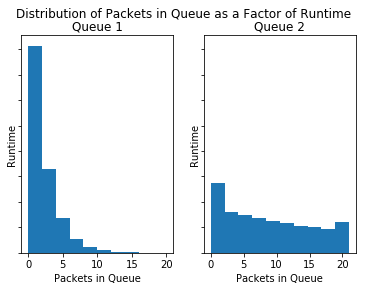


Simulation of two M/M/1/21 queues with phi=0.5:

	System:
		Blocking probability:
			Expected:  0.0018583868822537061
			Simulated:  0.0024095542324669935
		Average delay in seconds:
			Expected:  0.9609012148031506
			Simulated:  0.964106251469
		Average number of packets:
			Expected:  7.67292390872335
			Simulated:  7.68442640308
		Throughput in packets/second:
			Expected:  7.98513290494197
			Simulated:  7.97051817823

	Queue 1:
		Blocking probability:
			Expected:  0.0018583868822537061
			Simulated:  0.002025042355465108
		Average delay in seconds:
			Expected:  0.9609012148031506
			Simulated:  0.945655050572
		Average number of packets:
			Expected:  3.836461954361675
			Simulated:  3.76886579796
		Throughput in packets/second:
			Expected:  3.992566452470985
			Simulated:  3.98545515691

	Queue 2:
		Blocking probability:
			Expected:  0.0018583868822537061
			Simulated:  0.0027920148375645652
		Average delay in seconds:
			Expected:  0.9609012148031506
			Simulated:  0.98247

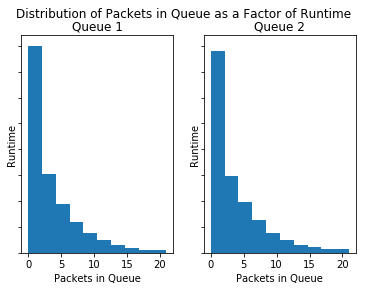


Simulation of two M/M/1/21 queues with phi=0.6:

	System:
		Blocking probability:
			Expected:  0.017195624672635433
			Simulated:  0.016262292791140456
		Average delay in seconds:
			Expected:  1.3552049632846765
			Simulated:  1.35473414539
		Average number of packets:
			Expected:  10.655210939052324
			Simulated:  10.7176423399
		Throughput in packets/second:
			Expected:  7.862435002618916
			Simulated:  7.91125135243

	Queue 1:
		Blocking probability:
			Expected:  0.028638956400712554
			Simulated:  0.027166353794827403
		Average delay in seconds:
			Expected:  1.9042505442339672
			Simulated:  1.89381657886
		Average number of packets:
			Expected:  8.878631020423763
			Simulated:  8.86961012042
		Throughput in packets/second:
			Expected:  4.662533009276579
			Simulated:  4.68345784878

	Queue 2:
		Blocking probability:
			Expected:  3.062708051975666e-05
			Simulated:  0.0
		Average delay in seconds:
			Expected:  0.5551982286722792
			Simulated:  0.572680245061
		Average nu

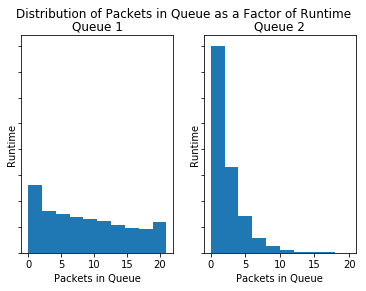

In [4]:
simulation(8, 5, 21, 0.4, 100000)
simulation(8, 5, 21, 0.5, 100000)
simulation(8, 5, 21, 0.6, 100000)

### Configuration 2:
* $\mu1 = 5\,packets/sec$
* $\mu2 = 5\,packets/sec$
* $\lambda = 8\,packets/sec$
* $buffer = 5$
* $\phi = 0.4, 0.5, 0.6$


Simulation of two M/M/1/6 queues with phi=0.4:

	System:
		Blocking probability:
			Expected:  0.08593320245468473
			Simulated:  0.08594998035877963
		Average delay in seconds:
			Expected:  0.5870317703261788
			Simulated:  0.589452697976
		Average number of packets:
			Expected:  4.292690002875259
			Simulated:  4.30754666181
		Throughput in packets/second:
			Expected:  7.312534380362522
			Simulated:  7.30770539621

	Queue 1:
		Blocking probability:
			Expected:  0.025877098450538878
			Simulated:  0.024711394989659956
		Average delay in seconds:
			Expected:  0.46700718583965284
			Simulated:  0.465549386763
		Average number of packets:
			Expected:  1.4557516637266275
			Simulated:  1.45231630721
		Throughput in packets/second:
			Expected:  3.117193284958276
			Simulated:  3.11957516968

	Queue 2:
		Blocking probability:
			Expected:  0.12597060512411531
			Simulated:  0.12680422273255154
		Average delay in seconds:
			Expected:  0.6762116058349422
			Simulated:  0.68177832707

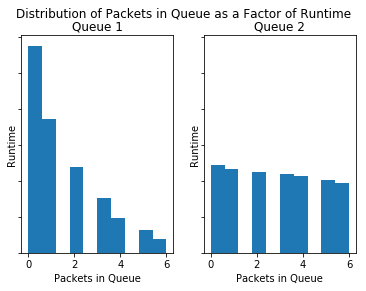


Simulation of two M/M/1/6 queues with phi=0.5:

	System:
		Blocking probability:
			Expected:  0.06634165303445037
			Simulated:  0.06478364090149234
		Average delay in seconds:
			Expected:  0.5736664064532917
			Simulated:  0.570126844906
		Average number of packets:
			Expected:  4.284867430070779
			Simulated:  4.27211982098
		Throughput in packets/second:
			Expected:  7.469266775724396
			Simulated:  7.49327953797

	Queue 1:
		Blocking probability:
			Expected:  0.06634165303445037
			Simulated:  0.06526751902815793
		Average delay in seconds:
			Expected:  0.5736664064532917
			Simulated:  0.568741778438
		Average number of packets:
			Expected:  2.1424337150353896
			Simulated:  2.12861255707
		Throughput in packets/second:
			Expected:  3.734633387862198
			Simulated:  3.7426695871

	Queue 2:
		Blocking probability:
			Expected:  0.06634165303445037
			Simulated:  0.06430061849110627
		Average delay in seconds:
			Expected:  0.5736664064532917
			Simulated:  0.571507964014
		

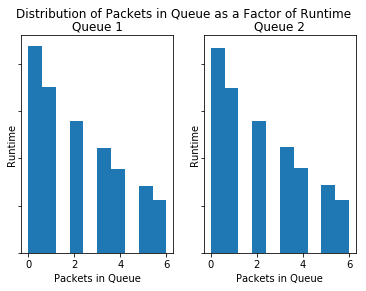


Simulation of two M/M/1/6 queues with phi=0.6:

	System:
		Blocking probability:
			Expected:  0.08593320245468473
			Simulated:  0.08735004256519265
		Average delay in seconds:
			Expected:  0.5870317703261788
			Simulated:  0.590218512672
		Average number of packets:
			Expected:  4.292690002875259
			Simulated:  4.33516681435
		Throughput in packets/second:
			Expected:  7.312534380362522
			Simulated:  7.34502005828

	Queue 1:
		Blocking probability:
			Expected:  0.12597060512411531
			Simulated:  0.12854341858742538
		Average delay in seconds:
			Expected:  0.6762116058349422
			Simulated:  0.681820905308
		Average number of packets:
			Expected:  2.836938339148631
			Simulated:  2.86751539667
		Throughput in packets/second:
			Expected:  4.195341095404246
			Simulated:  4.20567244908

	Queue 2:
		Blocking probability:
			Expected:  0.025877098450538878
			Simulated:  0.02573126857500391
		Average delay in seconds:
			Expected:  0.46700718583965284
			Simulated:  0.467657523845


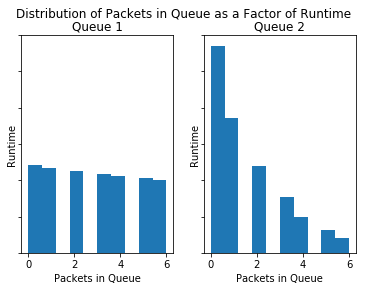

In [5]:
simulation(8, 5, 6, 0.4, 100000)
simulation(8, 5, 6, 0.5, 100000)
simulation(8, 5, 6, 0.6, 100000)

***

## Conclusions

The value of $\phi$ has an interesting impact on the system's behavior. As can be seen from the graphs, if $\phi$ is not equal then there is a queue being underutilized with too much runtime spent with too few packets in queue. This affects throughput negatively as can be seen from the results. Buffer size also plays an important role as it changes the probability that a packet will be blocked from entering the queue. A decrease in the buffer size will also negatively impact the throughput as the queue will not be able to utilize the full capability of the service rate.


From, the results of the simulations, the system with a buffer size of 20 and a $\phi$ of 0.5 is the best configuration. This is obvious from the observed results especially from the viewpoint of throughput. A larger buffer will allow better utilization of the service time with fewer blockings happening, and a $\phi$ of 0.5 will make sure a queue is not being underutilized. This at first seemed contrary because while this queue has a higher throughput, it's delay was actually worse than the queue with a buffer size of 5. However, that is because the queue can only hold 6 packets. The queue will have less delay because at most there will only be 5 packets ahead of another reducing the delay, but the queue itself is actually unreliable because it is blocking more packets. It will block packets more often and it won't be able to fully utilize its service time the way the size 20 buffer can.